In [241]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset

In [242]:
#torch data set
class dataSetAll(Dataset):
    def __init__(self, yearLow, yearHigh,numFeat,numOut):
        #import data from CSV
        self.df = pd.read_csv("data\FluViewPhase2Data\WHO_NREVSS_Combined_prior_to_2015_16.csv")
        self.df = self.df[(yearLow <= self.df["YEAR"]) & (self.df["YEAR"] < yearHigh)]["TOTAL"]

        self.numFeat = numFeat #------------------------
        self.numOut = numOut
        
        self.data = np.asarray(self.df,dtype=np.float32)
        self.norm = np.linalg.norm(self.data)
        self.data = self.data / self.norm
        self.data = torch.as_tensor(self.data)

    def __len__(self):
        return len(self.data)-self.numFeat-self.numOut
    
    def __getitem__(self,idx):
        # idx = 0
        return self.data[idx:idx+self.numFeat],self.data[idx+1:idx+self.numFeat+self.numOut]

In [243]:
#create data loaders
numFeat = 10
numOut = 1
train_data = dataSetAll(1900,2013,numFeat,numOut)
train_dataloader = DataLoader(train_data, batch_size=100,drop_last=False,shuffle=True)

In [244]:
# create our RNN based network with an RNN followed by a linear layer
inputSize = 1
sequenceLength = numFeat
numLayers = 1
hiddenSize = 32
batchSize = 100

class LSTM(nn.Module):
    def __init__(self,inputSize,hiddenSize,numLayers,numOut,sequenceLength,future=0):
        super(LSTM, self).__init__()
        self.inputSize = inputSize
        self.hiddenSize = hiddenSize
        self.numLayers = numLayers
        self.numOut = numOut
        self.future = future
        # print(batchSize,sequenceLength,inputSize)
        # self.LSTM = nn.LSTM(inputSize,hiddenSize,numLayers,batch_first=True)
        self.lstm = nn.LSTMCell(1,hiddenSize)
        # self.lstm2 = nn.LSTMCell(hiddenSize,hiddenSize,bias=False)
        self.fc = nn.Linear(hiddenSize,self.numOut)
        
    def forward(self,x):
        outputs = []
        nSamples = x.size(0)
        h_1 = torch.zeros(nSamples, self.hiddenSize, dtype=torch.float32)
        c_1 = torch.zeros(nSamples, self.hiddenSize, dtype=torch.float32)
        
        for input in x.split(1,dim=1):
            h_1, _ = self.lstm(input, (h_1,c_1))
            out = self.fc(h_1)
            outputs.append(out)

        for i in range(self.numOut-1):
            h_1, _ = self.lstm(input, (h_1,c_1))
            out = self.fc(h_1)
            outputs.append(out)

        outputs = torch.cat(outputs, dim=1)
        return outputs

    def predict(self,x,future):
        outputs = []
        nSamples = x.size(0)
        h_1 = torch.zeros(nSamples, self.hiddenSize, dtype=torch.float32)
        c_1 = torch.zeros(nSamples, self.hiddenSize, dtype=torch.float32)
        
        for input in x.split(1,dim=1):
            h_1, _ = self.lstm(input, (h_1,c_1))
            out = self.fc(h_1)
            outputs.append(out)

        for i in range(future-1):
            h_1, _ = self.lstm(input, (h_1,c_1))
            out = self.fc(h_1)
            outputs.append(out)

        outputs = torch.cat(outputs, dim=1)
        return outputs[-future+1::]

model = LSTM(inputSize,hiddenSize,numLayers,numOut,sequenceLength)

In [245]:
#train/test loop
def train_loop(dataloader, model, loss_fn, optimizer,t):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        # print(X.size())
        # X = X[:,:,None]
        pred = model(X)
        # print(pred.size())
        # print(y.size())
        # print("pred",pred.size())
        # print("Y",y.size())
        loss = loss_fn(pred, y)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % size == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss({t}): {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [246]:
learning_rate = .005
batch_size = 100
epochs = 200
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# print(list(model.parameters()))

# print(list(model.parameters()))
for t in range(epochs):
    # print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer,t)
    # test_loop(test_dataloader, model, loss_fn)

print("Done!")
# print(list(model.parameters()))

loss(0): 0.013291  [    0/  782]
loss(1): 0.002732  [    0/  782]
loss(2): 0.000912  [    0/  782]
loss(3): 0.001266  [    0/  782]
loss(4): 0.000523  [    0/  782]
loss(5): 0.000491  [    0/  782]


KeyboardInterrupt: 

tensor([0.1173, 0.1204, 0.1229, 0.1127, 0.0915, 0.0791, 0.0716, 0.0675, 0.0643,
        0.0631, 0.0638, 0.0640, 0.0638])


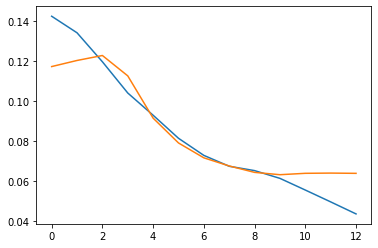

tensor([0.1309, 0.1080, 0.1123, 0.0969, 0.0817, 0.0703, 0.0659, 0.0642, 0.0634,
        0.0592, 0.0596, 0.0602, 0.0602])


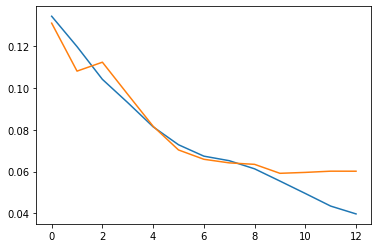

tensor([0.1241, 0.0991, 0.0976, 0.0869, 0.0718, 0.0643, 0.0631, 0.0635, 0.0594,
        0.0524, 0.0535, 0.0547, 0.0547])


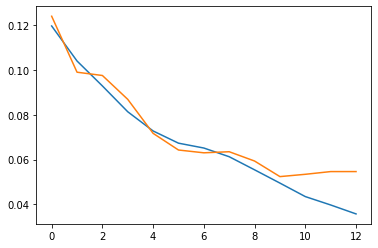

tensor([0.1119, 0.0903, 0.0876, 0.0756, 0.0648, 0.0618, 0.0630, 0.0595, 0.0526,
        0.0461, 0.0477, 0.0491, 0.0490])


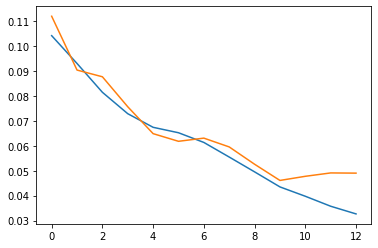

tensor([0.0984, 0.0847, 0.0764, 0.0676, 0.0617, 0.0621, 0.0593, 0.0527, 0.0462,
        0.0402, 0.0420, 0.0433, 0.0432])


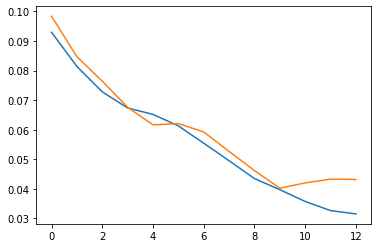

tensor([0.0886, 0.0767, 0.0688, 0.0633, 0.0616, 0.0586, 0.0525, 0.0463, 0.0404,
        0.0374, 0.0389, 0.0396, 0.0394])


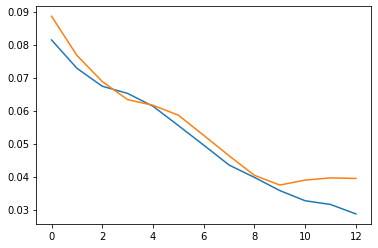

tensor([0.0782, 0.0709, 0.0643, 0.0624, 0.0581, 0.0519, 0.0462, 0.0405, 0.0375,
        0.0341, 0.0349, 0.0356, 0.0355])


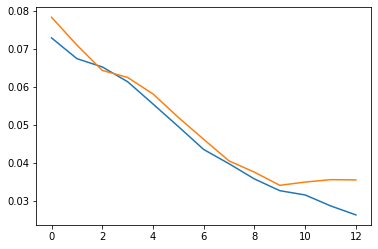

tensor([0.0705, 0.0672, 0.0630, 0.0586, 0.0515, 0.0456, 0.0404, 0.0377, 0.0342,
        0.0312, 0.0320, 0.0325, 0.0325])


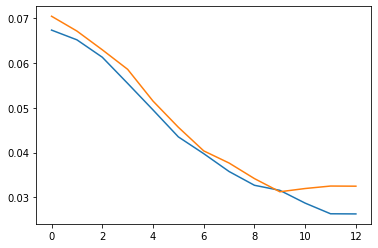

tensor([0.0655, 0.0659, 0.0592, 0.0521, 0.0452, 0.0398, 0.0376, 0.0343, 0.0313,
        0.0306, 0.0312, 0.0314, 0.0313])


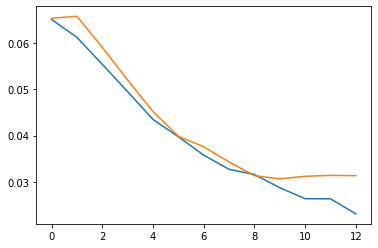

tensor([0.0635, 0.0623, 0.0532, 0.0458, 0.0393, 0.0370, 0.0342, 0.0314, 0.0307,
        0.0277, 0.0280, 0.0285, 0.0285])


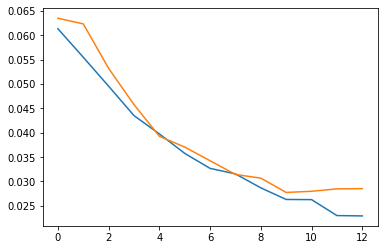

tensor([0.0599, 0.0569, 0.0474, 0.0396, 0.0363, 0.0338, 0.0314, 0.0308, 0.0278,
        0.0251, 0.0256, 0.0262, 0.0262])


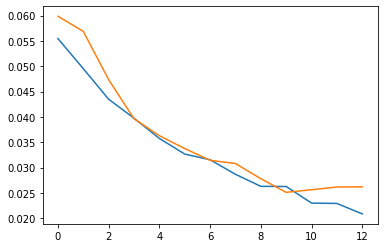

tensor([0.0544, 0.0514, 0.0415, 0.0365, 0.0329, 0.0310, 0.0309, 0.0280, 0.0252,
        0.0256, 0.0261, 0.0262, 0.0261])


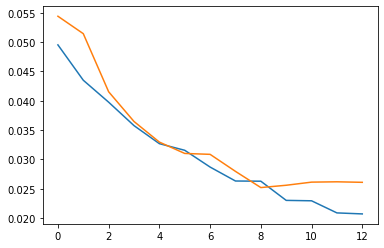

tensor([0.0488, 0.0457, 0.0383, 0.0329, 0.0302, 0.0305, 0.0280, 0.0253, 0.0256,
        0.0222, 0.0223, 0.0228, 0.0229])


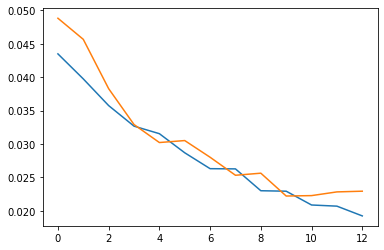

tensor([0.0431, 0.0422, 0.0346, 0.0301, 0.0298, 0.0277, 0.0254, 0.0257, 0.0223,
        0.0222, 0.0227, 0.0229, 0.0228])


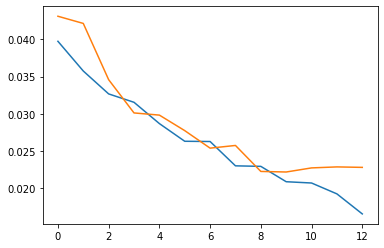

tensor([0.0395, 0.0381, 0.0317, 0.0297, 0.0271, 0.0251, 0.0258, 0.0224, 0.0222,
        0.0203, 0.0204, 0.0207, 0.0208])


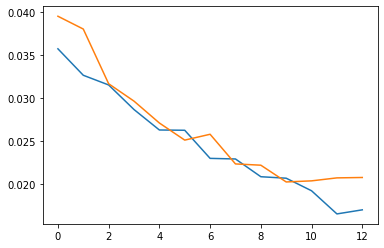

tensor([0.0357, 0.0349, 0.0310, 0.0269, 0.0246, 0.0256, 0.0224, 0.0223, 0.0203,
        0.0202, 0.0205, 0.0206, 0.0206])


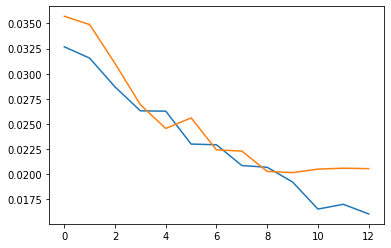

tensor([0.0327, 0.0338, 0.0281, 0.0244, 0.0251, 0.0223, 0.0224, 0.0204, 0.0202,
        0.0188, 0.0188, 0.0191, 0.0191])


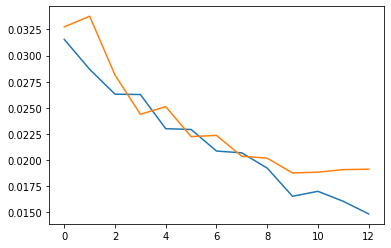

tensor([0.0317, 0.0306, 0.0256, 0.0249, 0.0218, 0.0222, 0.0204, 0.0203, 0.0188,
        0.0156, 0.0158, 0.0164, 0.0165])


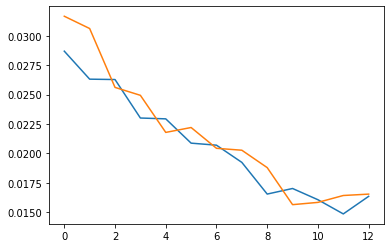

tensor([0.0289, 0.0280, 0.0260, 0.0216, 0.0218, 0.0203, 0.0203, 0.0189, 0.0157,
        0.0164, 0.0170, 0.0170, 0.0169])


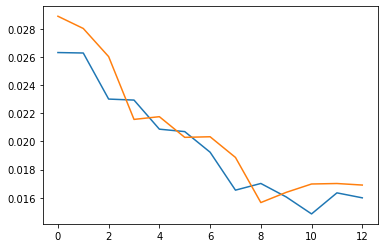

tensor([0.0266, 0.0280, 0.0225, 0.0216, 0.0199, 0.0202, 0.0189, 0.0157, 0.0164,
        0.0158, 0.0159, 0.0159, 0.0159])


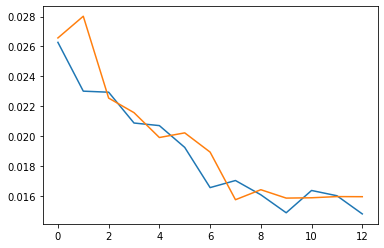

tensor([0.0265, 0.0243, 0.0225, 0.0197, 0.0199, 0.0188, 0.0158, 0.0165, 0.0158,
        0.0144, 0.0145, 0.0147, 0.0148])


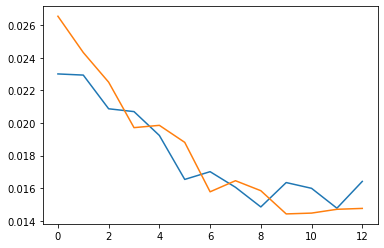

tensor([0.0233, 0.0243, 0.0206, 0.0196, 0.0185, 0.0157, 0.0165, 0.0159, 0.0144,
        0.0162, 0.0165, 0.0163, 0.0162])


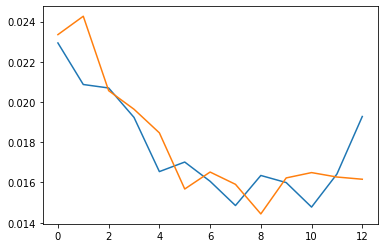

tensor([0.0233, 0.0219, 0.0204, 0.0183, 0.0154, 0.0164, 0.0160, 0.0145, 0.0162,
        0.0161, 0.0158, 0.0158, 0.0158])


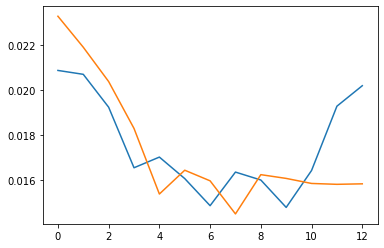

tensor([0.0213, 0.0217, 0.0190, 0.0152, 0.0161, 0.0159, 0.0145, 0.0163, 0.0161,
        0.0144, 0.0143, 0.0146, 0.0147])


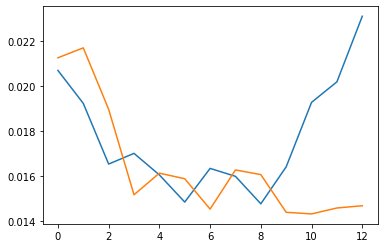

tensor([0.0211, 0.0200, 0.0158, 0.0160, 0.0156, 0.0145, 0.0163, 0.0161, 0.0144,
        0.0163, 0.0166, 0.0163, 0.0162])


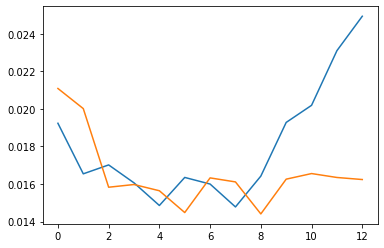

tensor([0.0197, 0.0169, 0.0166, 0.0154, 0.0142, 0.0163, 0.0162, 0.0144, 0.0163,
        0.0199, 0.0197, 0.0191, 0.0190])


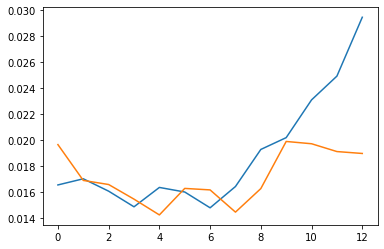

tensor([0.0170, 0.0174, 0.0159, 0.0140, 0.0161, 0.0161, 0.0145, 0.0163, 0.0199,
        0.0208, 0.0202, 0.0199, 0.0199])


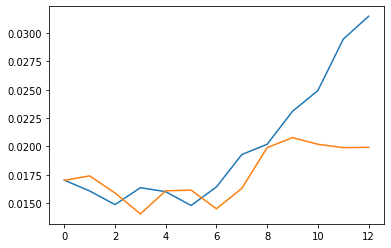

tensor([0.0175, 0.0163, 0.0144, 0.0159, 0.0160, 0.0145, 0.0163, 0.0199, 0.0208,
        0.0236, 0.0233, 0.0228, 0.0228])


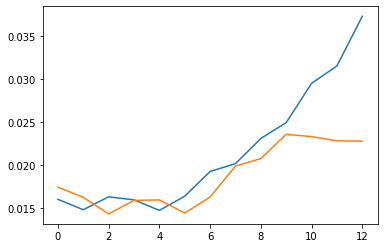

tensor([0.0165, 0.0149, 0.0163, 0.0158, 0.0143, 0.0163, 0.0199, 0.0208, 0.0236,
        0.0255, 0.0250, 0.0246, 0.0246])


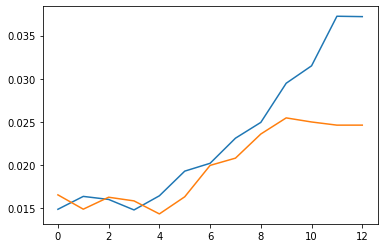

tensor([0.0153, 0.0166, 0.0161, 0.0142, 0.0162, 0.0199, 0.0208, 0.0236, 0.0255,
        0.0303, 0.0299, 0.0291, 0.0290])


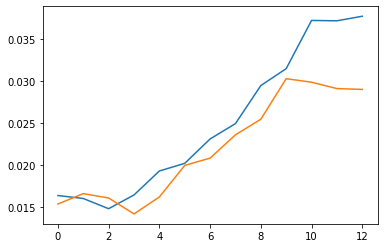

tensor([0.0168, 0.0162, 0.0144, 0.0161, 0.0199, 0.0208, 0.0236, 0.0255, 0.0303,
        0.0322, 0.0314, 0.0310, 0.0310])


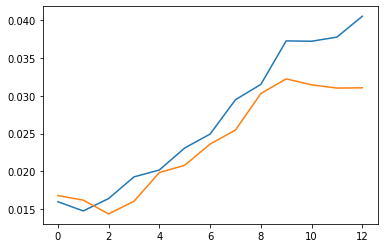

tensor([0.0165, 0.0148, 0.0163, 0.0197, 0.0207, 0.0236, 0.0255, 0.0303, 0.0322,
        0.0382, 0.0376, 0.0367, 0.0366])


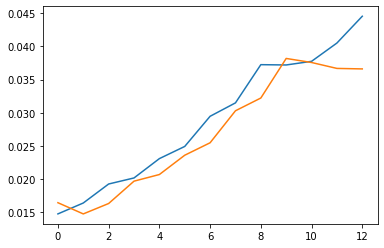

tensor([0.0153, 0.0167, 0.0199, 0.0206, 0.0235, 0.0255, 0.0303, 0.0322, 0.0382,
        0.0375, 0.0366, 0.0366, 0.0367])


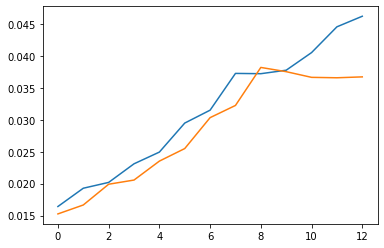

tensor([0.0169, 0.0200, 0.0207, 0.0234, 0.0254, 0.0303, 0.0323, 0.0382, 0.0375,
        0.0373, 0.0372, 0.0372, 0.0373])


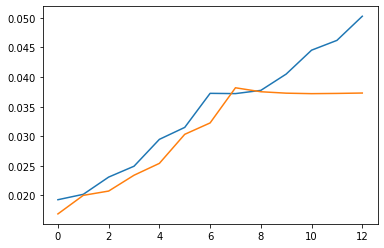

tensor([0.0197, 0.0211, 0.0237, 0.0253, 0.0302, 0.0322, 0.0382, 0.0375, 0.0373,
        0.0405, 0.0404, 0.0400, 0.0399])


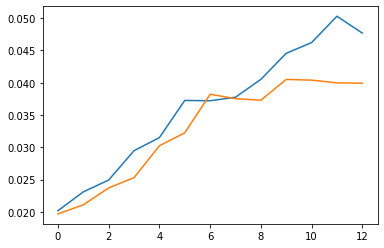

tensor([0.0206, 0.0245, 0.0257, 0.0301, 0.0321, 0.0382, 0.0375, 0.0373, 0.0405,
        0.0452, 0.0445, 0.0438, 0.0438])


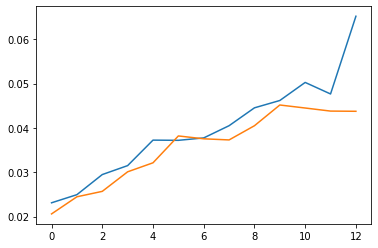

tensor([0.0234, 0.0265, 0.0305, 0.0320, 0.0381, 0.0375, 0.0373, 0.0405, 0.0452,
        0.0465, 0.0457, 0.0454, 0.0454])


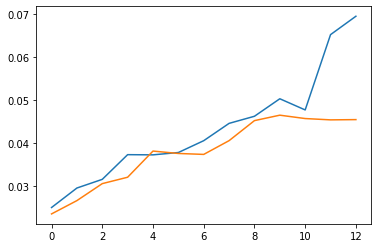

tensor([0.0252, 0.0317, 0.0324, 0.0379, 0.0374, 0.0373, 0.0405, 0.0452, 0.0465,
        0.0505, 0.0499, 0.0493, 0.0493])


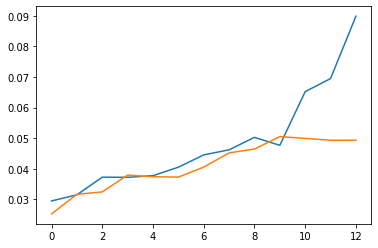

tensor([0.0297, 0.0338, 0.0384, 0.0372, 0.0371, 0.0405, 0.0452, 0.0465, 0.0505,
        0.0468, 0.0464, 0.0468, 0.0470])


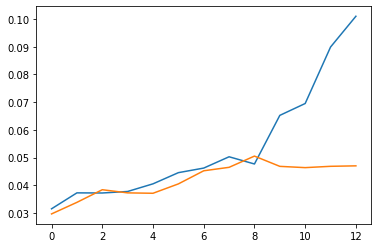

tensor([0.0316, 0.0401, 0.0377, 0.0370, 0.0403, 0.0452, 0.0465, 0.0505, 0.0468,
        0.0675, 0.0656, 0.0635, 0.0635])


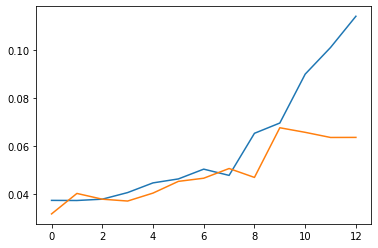

tensor([0.0371, 0.0398, 0.0378, 0.0402, 0.0450, 0.0464, 0.0506, 0.0468, 0.0675,
        0.0706, 0.0680, 0.0676, 0.0677])


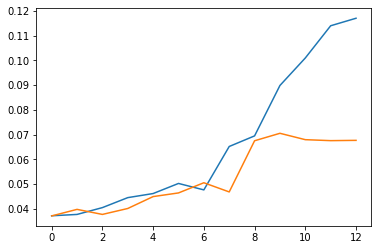

tensor([0.0371, 0.0404, 0.0409, 0.0447, 0.0462, 0.0505, 0.0469, 0.0675, 0.0705,
        0.0919, 0.0883, 0.0866, 0.0868])


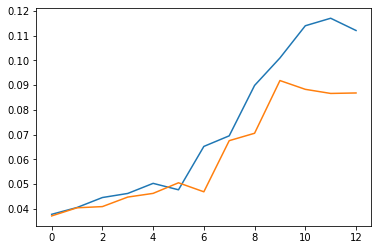

tensor([0.0376, 0.0434, 0.0452, 0.0460, 0.0503, 0.0468, 0.0676, 0.0705, 0.0918,
        0.1012, 0.0978, 0.0971, 0.0972])


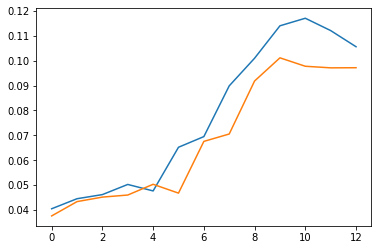

tensor([0.0403, 0.0476, 0.0464, 0.0502, 0.0466, 0.0676, 0.0706, 0.0918, 0.1011,
        0.1133, 0.1103, 0.1090, 0.1091])


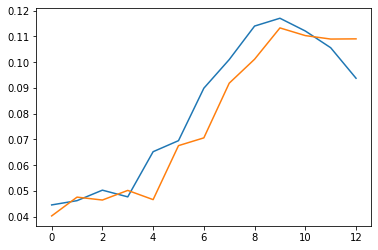

tensor([0.0441, 0.0490, 0.0505, 0.0465, 0.0675, 0.0707, 0.0919, 0.1011, 0.1133,
        0.1141, 0.1122, 0.1118, 0.1120])


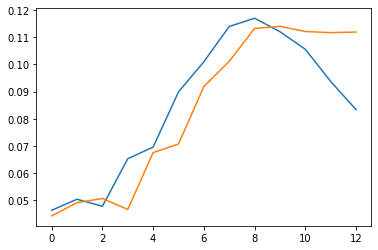

tensor([0.0457, 0.0532, 0.0470, 0.0672, 0.0706, 0.0920, 0.1012, 0.1133, 0.1141,
        0.1057, 0.1062, 0.1077, 0.1079])


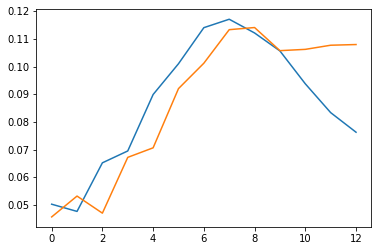

tensor([0.0495, 0.0500, 0.0668, 0.0702, 0.0922, 0.1013, 0.1133, 0.1141, 0.1057,
        0.0973, 0.1002, 0.1024, 0.1021])


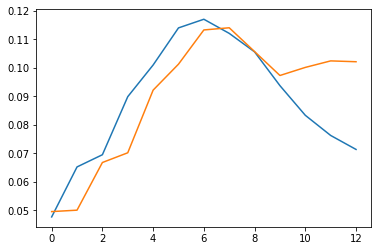

tensor([0.0471, 0.0688, 0.0687, 0.0919, 0.1014, 0.1133, 0.1141, 0.1057, 0.0973,
        0.0837, 0.0885, 0.0921, 0.0913])


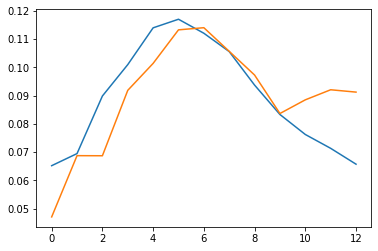

tensor([0.0635, 0.0706, 0.0898, 0.1009, 0.1135, 0.1140, 0.1057, 0.0973, 0.0837,
        0.0741, 0.0800, 0.0824, 0.0813])


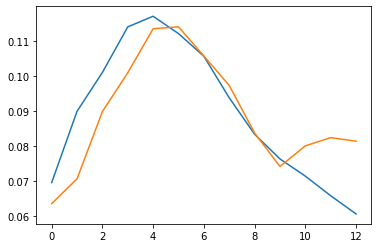

tensor([0.0674, 0.0899, 0.0968, 0.1134, 0.1143, 0.1058, 0.0973, 0.0836, 0.0740,
        0.0705, 0.0745, 0.0751, 0.0745])


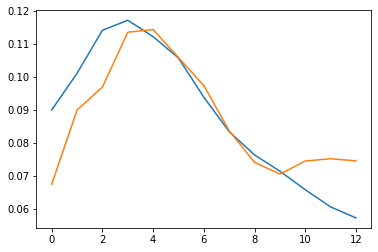

tensor([0.0859, 0.0957, 0.1091, 0.1144, 0.1065, 0.0975, 0.0834, 0.0738, 0.0704,
        0.0682, 0.0698, 0.0701, 0.0698])


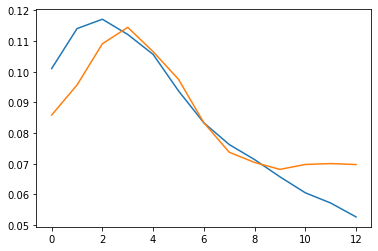

tensor([0.0957, 0.1044, 0.1099, 0.1081, 0.0989, 0.0835, 0.0731, 0.0700, 0.0682,
        0.0628, 0.0638, 0.0646, 0.0644])


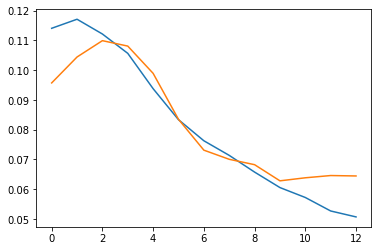

tensor([0.1070, 0.1032, 0.1053, 0.1014, 0.0850, 0.0728, 0.0691, 0.0680, 0.0630,
        0.0574, 0.0587, 0.0596, 0.0595])


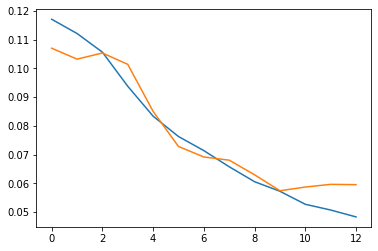

tensor([0.1096, 0.0980, 0.0998, 0.0883, 0.0743, 0.0683, 0.0672, 0.0629, 0.0576,
        0.0546, 0.0558, 0.0564, 0.0563])


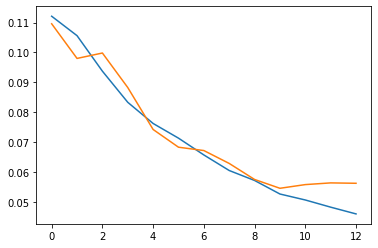

tensor([0.1053, 0.0938, 0.0880, 0.0778, 0.0691, 0.0662, 0.0623, 0.0576, 0.0548,
        0.0503, 0.0512, 0.0520, 0.0520])


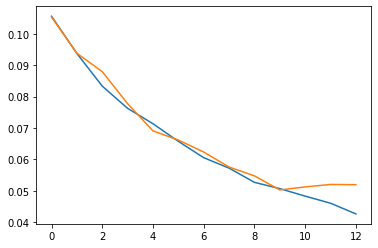

tensor([0.0997, 0.0850, 0.0785, 0.0717, 0.0661, 0.0614, 0.0572, 0.0548, 0.0504,
        0.0488, 0.0497, 0.0501, 0.0500])


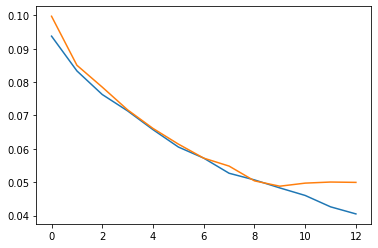

tensor([0.0893, 0.0784, 0.0724, 0.0677, 0.0611, 0.0565, 0.0546, 0.0505, 0.0489,
        0.0468, 0.0473, 0.0477, 0.0476])


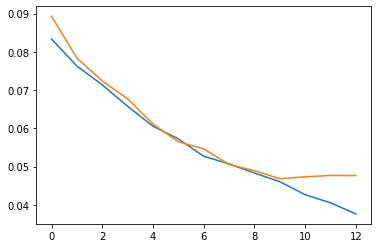

tensor([0.0800, 0.0739, 0.0682, 0.0622, 0.0561, 0.0540, 0.0504, 0.0490, 0.0469,
        0.0446, 0.0451, 0.0455, 0.0455])


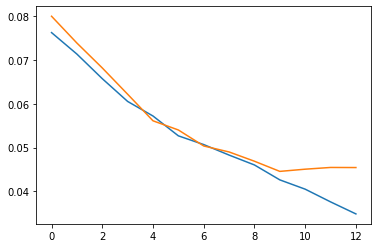

tensor([0.0736, 0.0705, 0.0629, 0.0570, 0.0536, 0.0499, 0.0489, 0.0470, 0.0446,
        0.0409, 0.0415, 0.0422, 0.0422])


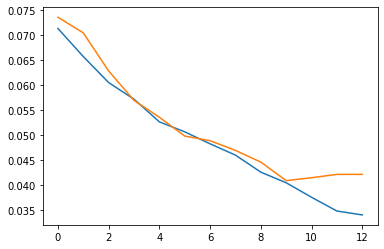

tensor([0.0691, 0.0658, 0.0580, 0.0542, 0.0493, 0.0485, 0.0470, 0.0447, 0.0410,
        0.0389, 0.0397, 0.0402, 0.0401])


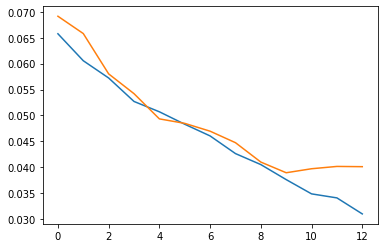

tensor([0.0640, 0.0615, 0.0552, 0.0497, 0.0479, 0.0466, 0.0447, 0.0411, 0.0390,
        0.0362, 0.0368, 0.0373, 0.0373])


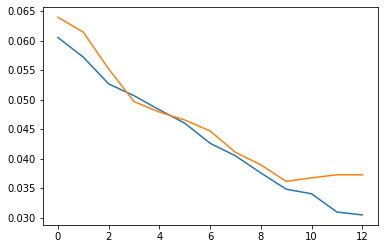

tensor([0.0592, 0.0588, 0.0508, 0.0482, 0.0460, 0.0444, 0.0411, 0.0391, 0.0362,
        0.0334, 0.0341, 0.0346, 0.0346])


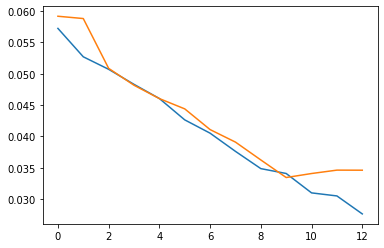

tensor([0.0561, 0.0545, 0.0493, 0.0461, 0.0439, 0.0408, 0.0391, 0.0363, 0.0335,
        0.0331, 0.0337, 0.0339, 0.0338])


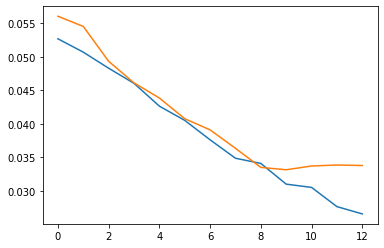

tensor([0.0518, 0.0530, 0.0472, 0.0439, 0.0402, 0.0388, 0.0364, 0.0336, 0.0332,
        0.0300, 0.0302, 0.0307, 0.0308])


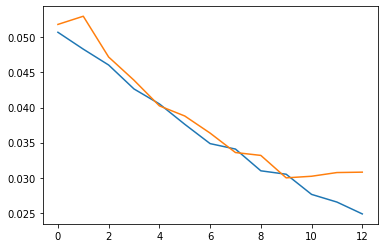

tensor([0.0499, 0.0507, 0.0450, 0.0403, 0.0383, 0.0361, 0.0336, 0.0333, 0.0300,
        0.0296, 0.0302, 0.0303, 0.0303])


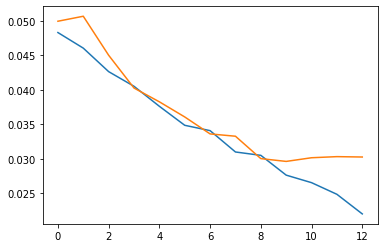

tensor([0.0477, 0.0485, 0.0415, 0.0383, 0.0355, 0.0333, 0.0333, 0.0301, 0.0297,
        0.0267, 0.0269, 0.0274, 0.0275])


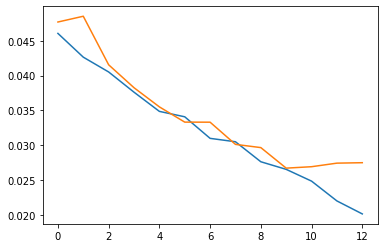

tensor([0.0455, 0.0451, 0.0396, 0.0354, 0.0327, 0.0331, 0.0302, 0.0298, 0.0268,
        0.0256, 0.0261, 0.0264, 0.0264])


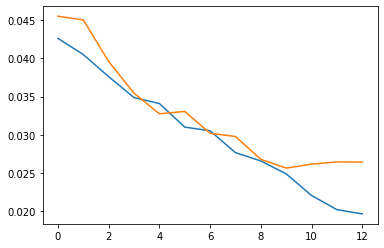

tensor([0.0423, 0.0430, 0.0368, 0.0326, 0.0325, 0.0299, 0.0298, 0.0269, 0.0257,
        0.0241, 0.0244, 0.0247, 0.0247])


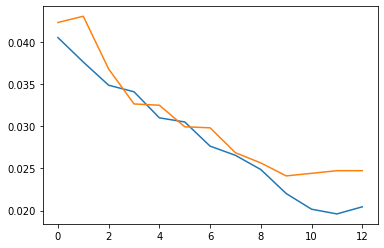

tensor([0.0403, 0.0400, 0.0340, 0.0324, 0.0294, 0.0296, 0.0269, 0.0257, 0.0241,
        0.0210, 0.0213, 0.0219, 0.0220])


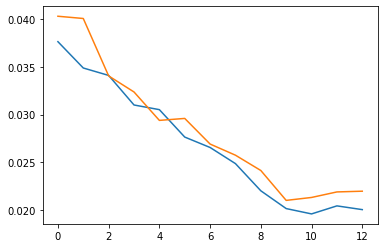

tensor([0.0375, 0.0372, 0.0336, 0.0292, 0.0291, 0.0267, 0.0258, 0.0242, 0.0211,
        0.0191, 0.0197, 0.0201, 0.0201])


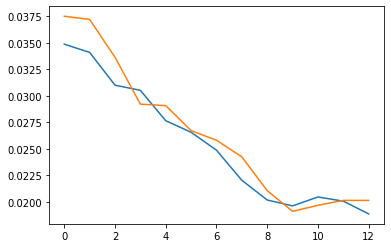

tensor([0.0349, 0.0365, 0.0304, 0.0289, 0.0262, 0.0256, 0.0243, 0.0211, 0.0191,
        0.0190, 0.0194, 0.0196, 0.0195])


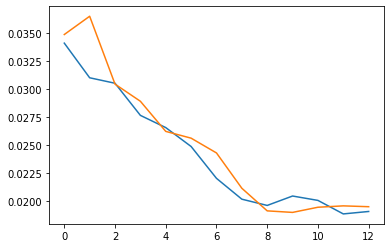

tensor([0.0341, 0.0331, 0.0301, 0.0260, 0.0251, 0.0241, 0.0212, 0.0192, 0.0190,
        0.0204, 0.0205, 0.0203, 0.0202])


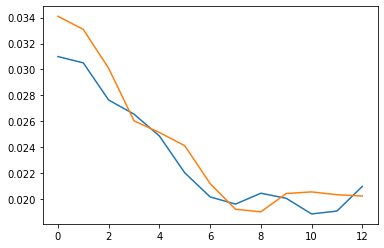

tensor([0.0311, 0.0327, 0.0272, 0.0249, 0.0237, 0.0210, 0.0193, 0.0191, 0.0204,
        0.0201, 0.0199, 0.0198, 0.0199])


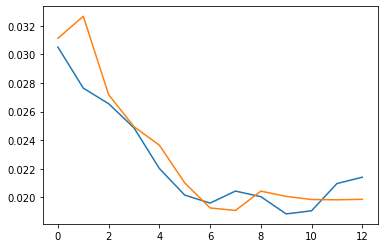

tensor([0.0307, 0.0295, 0.0261, 0.0235, 0.0206, 0.0191, 0.0192, 0.0205, 0.0201,
        0.0184, 0.0184, 0.0187, 0.0187])


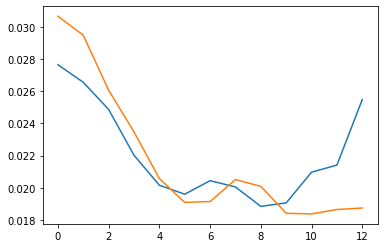

tensor([0.0279, 0.0283, 0.0245, 0.0204, 0.0187, 0.0190, 0.0206, 0.0202, 0.0184,
        0.0186, 0.0189, 0.0190, 0.0189])


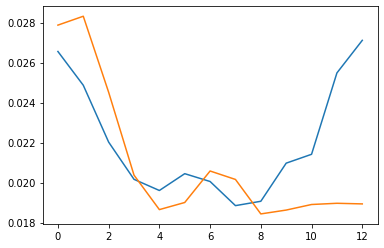

tensor([0.0268, 0.0264, 0.0214, 0.0185, 0.0186, 0.0205, 0.0202, 0.0185, 0.0186,
        0.0211, 0.0212, 0.0208, 0.0207])


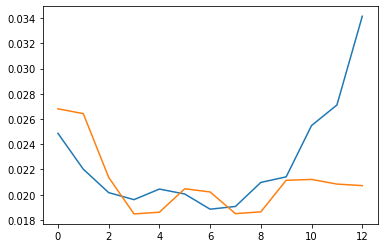

tensor([0.0252, 0.0232, 0.0195, 0.0184, 0.0201, 0.0201, 0.0186, 0.0187, 0.0211,
        0.0217, 0.0214, 0.0212, 0.0212])


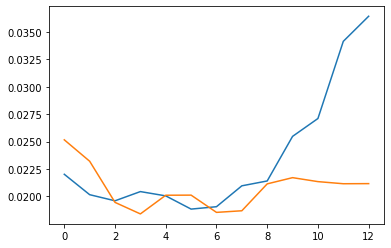

tensor([0.0224, 0.0211, 0.0192, 0.0199, 0.0198, 0.0185, 0.0187, 0.0212, 0.0217,
        0.0261, 0.0259, 0.0252, 0.0251])


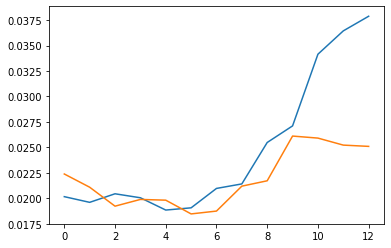

tensor([0.0206, 0.0204, 0.0205, 0.0196, 0.0182, 0.0187, 0.0212, 0.0218, 0.0261,
        0.0278, 0.0271, 0.0267, 0.0267])


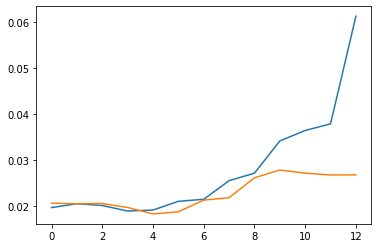

tensor([0.0200, 0.0214, 0.0201, 0.0181, 0.0185, 0.0212, 0.0218, 0.0261, 0.0278,
        0.0353, 0.0348, 0.0337, 0.0335])


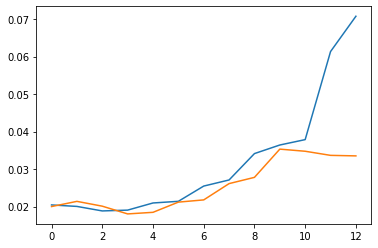

tensor([0.0208, 0.0210, 0.0186, 0.0183, 0.0210, 0.0218, 0.0262, 0.0278, 0.0353,
        0.0374, 0.0363, 0.0358, 0.0359])


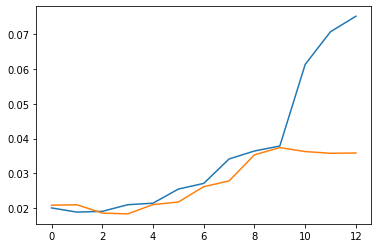

tensor([0.0205, 0.0196, 0.0189, 0.0208, 0.0216, 0.0261, 0.0279, 0.0354, 0.0374,
        0.0380, 0.0374, 0.0373, 0.0374])


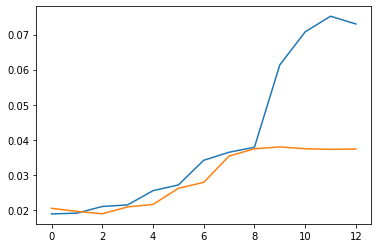

tensor([0.0193, 0.0198, 0.0213, 0.0214, 0.0260, 0.0278, 0.0354, 0.0374, 0.0380,
        0.0651, 0.0620, 0.0597, 0.0598])


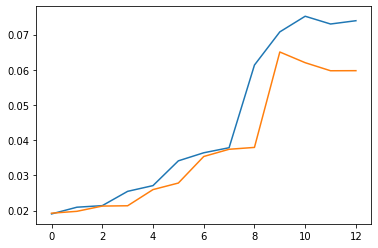

tensor([0.0195, 0.0220, 0.0218, 0.0258, 0.0277, 0.0354, 0.0375, 0.0380, 0.0651,
        0.0725, 0.0694, 0.0688, 0.0688])


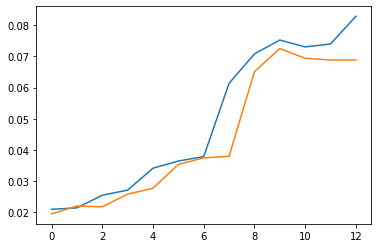

tensor([0.0214, 0.0225, 0.0262, 0.0276, 0.0353, 0.0374, 0.0380, 0.0651, 0.0725,
        0.0745, 0.0736, 0.0730, 0.0731])


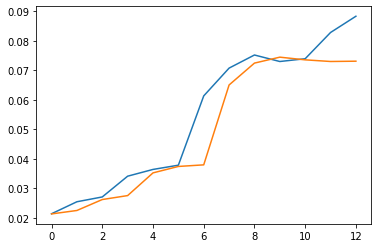

tensor([0.0218, 0.0272, 0.0280, 0.0351, 0.0373, 0.0380, 0.0651, 0.0725, 0.0745,
        0.0709, 0.0706, 0.0711, 0.0713])


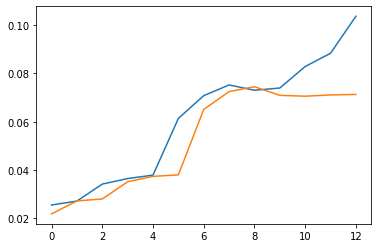

tensor([0.0258, 0.0290, 0.0355, 0.0372, 0.0379, 0.0651, 0.0725, 0.0745, 0.0709,
        0.0717, 0.0721, 0.0721, 0.0722])


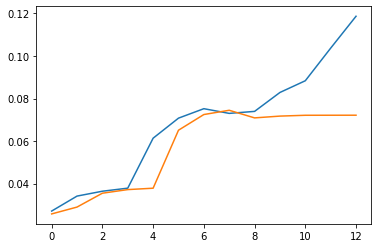

tensor([0.0274, 0.0369, 0.0375, 0.0377, 0.0651, 0.0726, 0.0745, 0.0709, 0.0717,
        0.0833, 0.0816, 0.0802, 0.0804])


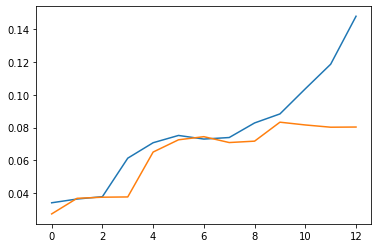

tensor([0.0342, 0.0391, 0.0383, 0.0648, 0.0727, 0.0745, 0.0709, 0.0717, 0.0833,
        0.0883, 0.0860, 0.0854, 0.0855])


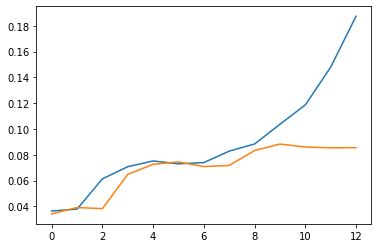

tensor([0.0364, 0.0406, 0.0644, 0.0723, 0.0747, 0.0708, 0.0717, 0.0833, 0.0883,
        0.1046, 0.1010, 0.0995, 0.0997])


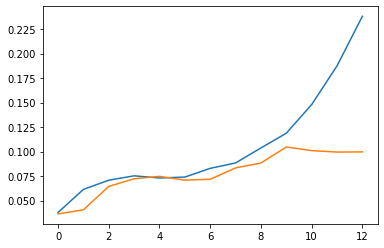

tensor([0.0377, 0.0658, 0.0709, 0.0746, 0.0710, 0.0717, 0.0833, 0.0883, 0.1046,
        0.1190, 0.1143, 0.1132, 0.1133])


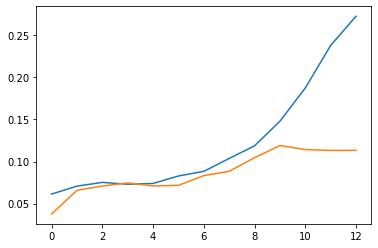

tensor([0.0599, 0.0725, 0.0737, 0.0711, 0.0718, 0.0832, 0.0883, 0.1047, 0.1190,
        0.1495, 0.1404, 0.1395, 0.1394])


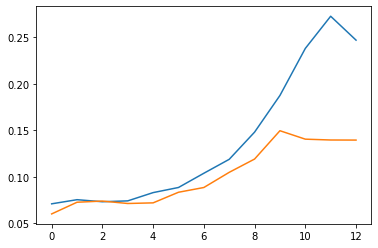

tensor([0.0686, 0.0753, 0.0704, 0.0723, 0.0832, 0.0883, 0.1048, 0.1190, 0.1495,
        0.1866, 0.1734, 0.1746, 0.1735])


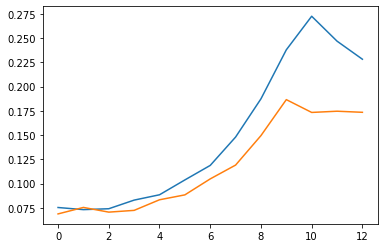

tensor([0.0727, 0.0723, 0.0718, 0.0832, 0.0882, 0.1048, 0.1191, 0.1495, 0.1866,
        0.2315, 0.2157, 0.2185, 0.2163])


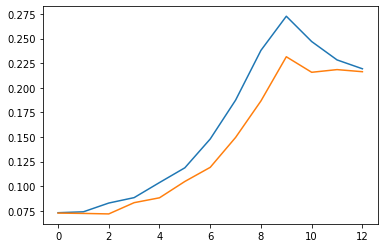

tensor([0.0706, 0.0736, 0.0814, 0.0881, 0.1049, 0.1191, 0.1496, 0.1867, 0.2316,
        0.2560, 0.2487, 0.2465, 0.2449])


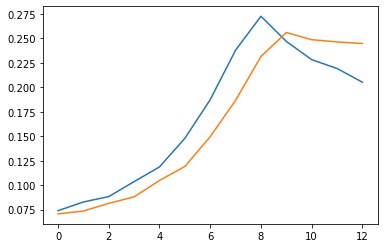

tensor([0.0715, 0.0821, 0.0855, 0.1047, 0.1191, 0.1495, 0.1868, 0.2316, 0.2560,
        0.2151, 0.2171, 0.2243, 0.2268])


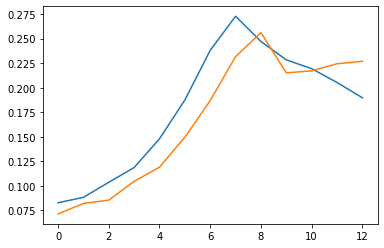

tensor([0.0796, 0.0855, 0.1010, 0.1186, 0.1492, 0.1864, 0.2316, 0.2559, 0.2151,
        0.1880, 0.2001, 0.2149, 0.2116])


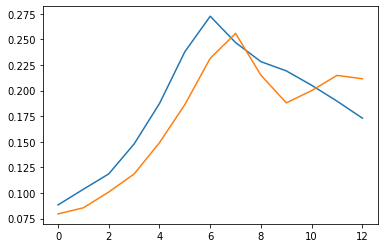

tensor([0.0845, 0.0985, 0.1129, 0.1482, 0.1847, 0.2304, 0.2555, 0.2153, 0.1885,
        0.1853, 0.2040, 0.2061, 0.2015])


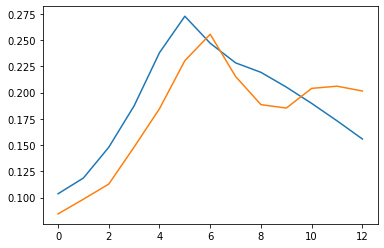

tensor([0.0980, 0.1077, 0.1399, 0.1821, 0.2266, 0.2538, 0.2162, 0.1902, 0.1854,
        0.1809, 0.1909, 0.1922, 0.1894])


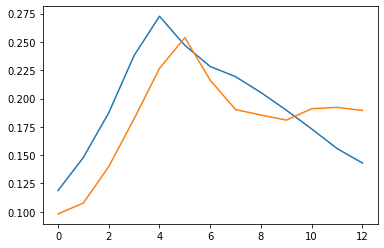

tensor([0.1110, 0.1274, 0.1700, 0.2213, 0.2473, 0.2177, 0.1945, 0.1863, 0.1789,
        0.1661, 0.1753, 0.1789, 0.1767])


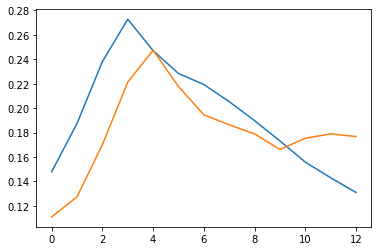

tensor([0.1354, 0.1461, 0.2081, 0.2371, 0.2171, 0.2015, 0.1893, 0.1762, 0.1637,
        0.1499, 0.1609, 0.1651, 0.1625])


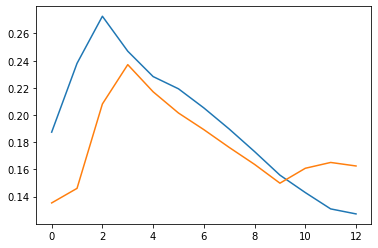

tensor([0.1665, 0.1616, 0.2327, 0.2051, 0.2093, 0.1964, 0.1752, 0.1596, 0.1483,
        0.1355, 0.1463, 0.1498, 0.1473])


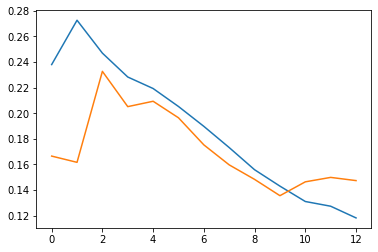

tensor([0.2034, 0.1563, 0.2218, 0.1997, 0.2018, 0.1802, 0.1584, 0.1449, 0.1345,
        0.1282, 0.1362, 0.1374, 0.1357])


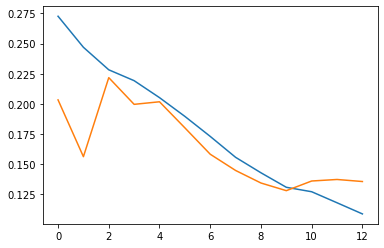

tensor([0.2268, 0.1262, 0.2255, 0.1924, 0.1855, 0.1636, 0.1432, 0.1310, 0.1275,
        0.1198, 0.1247, 0.1261, 0.1250])


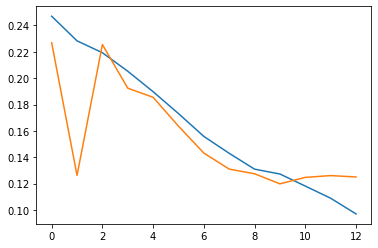

tensor([0.2096, 0.1278, 0.2138, 0.1816, 0.1702, 0.1471, 0.1278, 0.1241, 0.1199,
        0.1205, 0.1223, 0.1219, 0.1215])


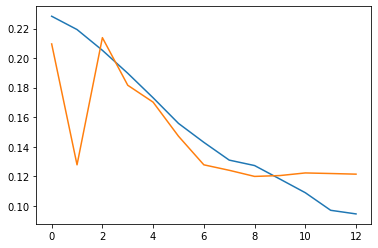

tensor([0.1966, 0.1311, 0.1965, 0.1716, 0.1540, 0.1301, 0.1200, 0.1174, 0.1212,
        0.1105, 0.1120, 0.1137, 0.1134])


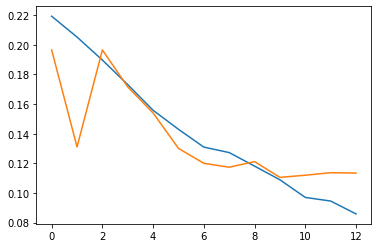

tensor([0.1901, 0.1266, 0.1822, 0.1588, 0.1370, 0.1209, 0.1131, 0.1197, 0.1113,
        0.0999, 0.1033, 0.1056, 0.1051])


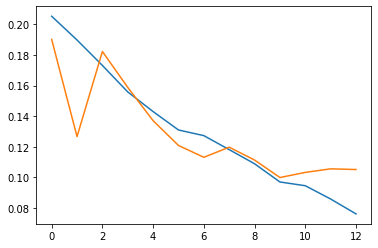

tensor([0.1799, 0.1230, 0.1658, 0.1445, 0.1270, 0.1126, 0.1161, 0.1107, 0.1005,
        0.0873, 0.0919, 0.0950, 0.0942])


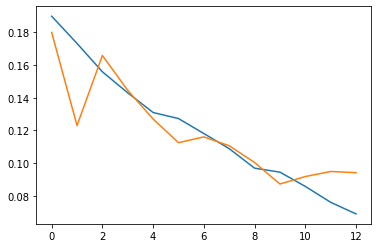

tensor([0.1682, 0.1185, 0.1485, 0.1348, 0.1172, 0.1149, 0.1080, 0.0998, 0.0877,
        0.0890, 0.0923, 0.0921, 0.0916])


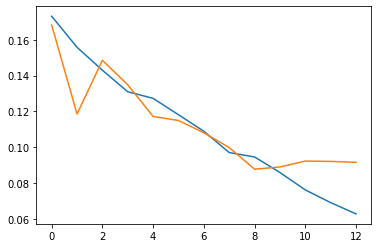

tensor([0.1554, 0.1130, 0.1363, 0.1241, 0.1178, 0.1069, 0.0978, 0.0871, 0.0893,
        0.0811, 0.0825, 0.0838, 0.0836])


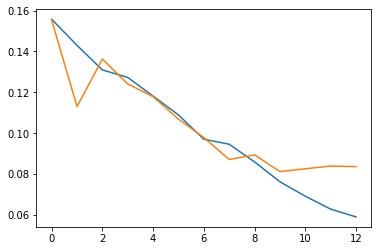

tensor([0.1417, 0.1100, 0.1239, 0.1231, 0.1088, 0.0971, 0.0855, 0.0889, 0.0814,
        0.0701, 0.0727, 0.0749, 0.0745])


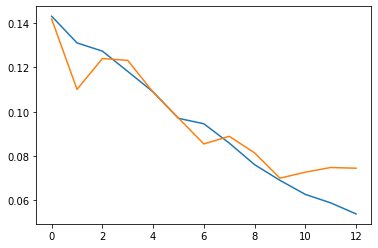

tensor([0.1313, 0.1052, 0.1213, 0.1129, 0.0993, 0.0849, 0.0876, 0.0812, 0.0702,
        0.0636, 0.0667, 0.0682, 0.0678])


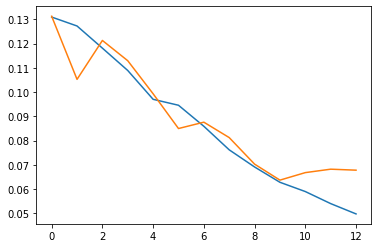

tensor([0.1213, 0.1063, 0.1110, 0.1037, 0.0871, 0.0867, 0.0801, 0.0700, 0.0638,
        0.0588, 0.0610, 0.0620, 0.0617])


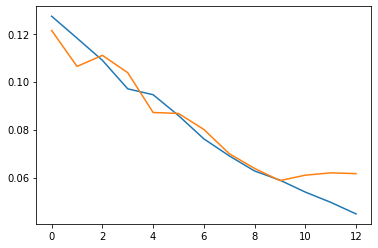

tensor([0.1182, 0.1000, 0.1028, 0.0913, 0.0880, 0.0790, 0.0690, 0.0636, 0.0590,
        0.0563, 0.0577, 0.0581, 0.0579])


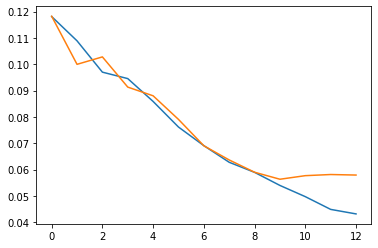

tensor([0.1105, 0.0949, 0.0911, 0.0912, 0.0795, 0.0681, 0.0629, 0.0589, 0.0565,
        0.0516, 0.0525, 0.0532, 0.0532])


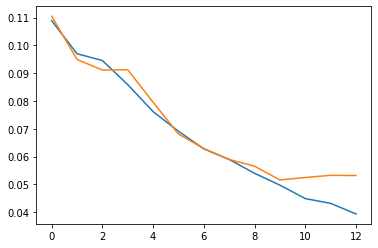

tensor([0.1026, 0.0871, 0.0905, 0.0818, 0.0686, 0.0621, 0.0584, 0.0565, 0.0517,
        0.0472, 0.0483, 0.0491, 0.0491])


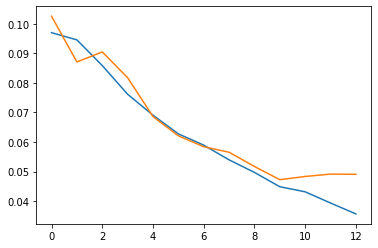

tensor([0.0922, 0.0880, 0.0810, 0.0710, 0.0625, 0.0575, 0.0561, 0.0518, 0.0474,
        0.0424, 0.0435, 0.0445, 0.0444])


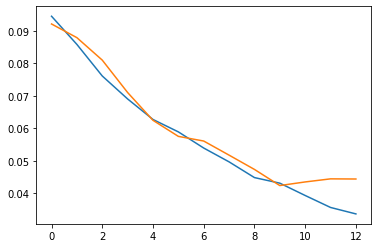

tensor([0.0900, 0.0805, 0.0718, 0.0645, 0.0574, 0.0553, 0.0515, 0.0475, 0.0425,
        0.0414, 0.0425, 0.0428, 0.0426])


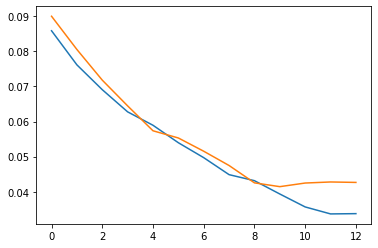

tensor([0.0823, 0.0732, 0.0656, 0.0587, 0.0548, 0.0509, 0.0473, 0.0426, 0.0415,
        0.0379, 0.0384, 0.0390, 0.0390])


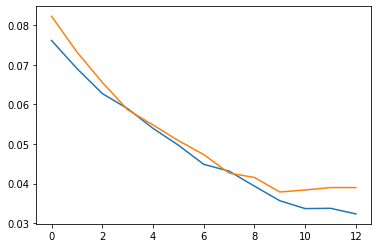

tensor([0.0735, 0.0683, 0.0598, 0.0556, 0.0503, 0.0467, 0.0425, 0.0417, 0.0379,
        0.0339, 0.0346, 0.0354, 0.0354])


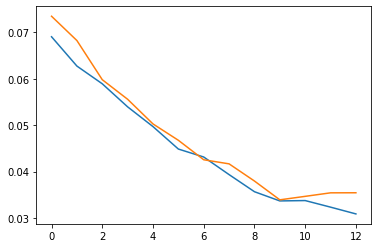

tensor([0.0670, 0.0632, 0.0567, 0.0507, 0.0461, 0.0420, 0.0416, 0.0381, 0.0340,
        0.0322, 0.0331, 0.0335, 0.0334])


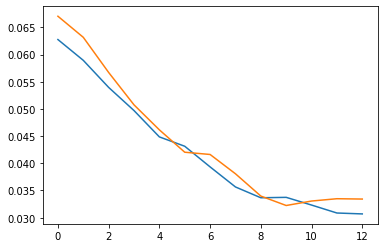

tensor([0.0612, 0.0602, 0.0519, 0.0465, 0.0414, 0.0412, 0.0381, 0.0341, 0.0323,
        0.0331, 0.0336, 0.0335, 0.0334])


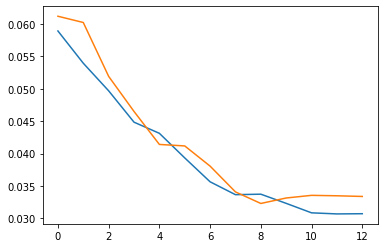

tensor([0.0576, 0.0556, 0.0479, 0.0417, 0.0405, 0.0377, 0.0341, 0.0324, 0.0332,
        0.0319, 0.0318, 0.0320, 0.0320])


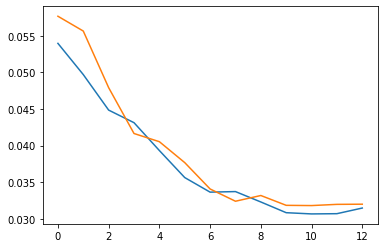

tensor([0.0530, 0.0518, 0.0432, 0.0406, 0.0370, 0.0337, 0.0324, 0.0333, 0.0319,
        0.0301, 0.0303, 0.0306, 0.0306])


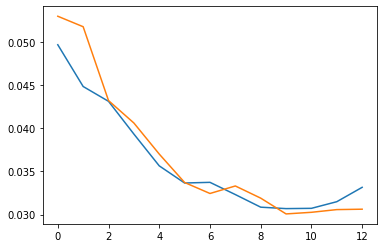

tensor([0.0490, 0.0471, 0.0421, 0.0370, 0.0331, 0.0321, 0.0334, 0.0320, 0.0301,
        0.0301, 0.0304, 0.0305, 0.0304])


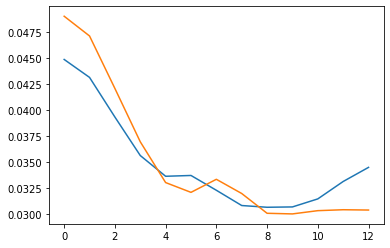

tensor([0.0444, 0.0457, 0.0383, 0.0330, 0.0315, 0.0331, 0.0321, 0.0302, 0.0301,
        0.0304, 0.0305, 0.0304, 0.0304])


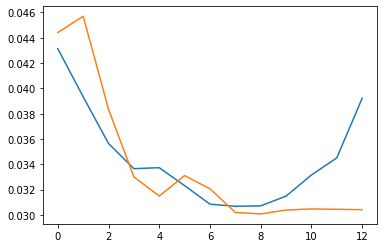

tensor([0.0428, 0.0417, 0.0345, 0.0314, 0.0325, 0.0319, 0.0303, 0.0302, 0.0304,
        0.0314, 0.0313, 0.0312, 0.0311])


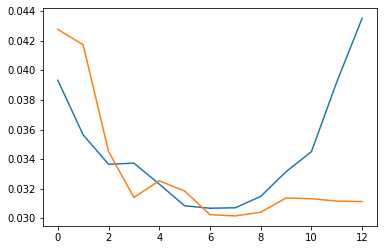

tensor([0.0391, 0.0380, 0.0329, 0.0323, 0.0313, 0.0301, 0.0302, 0.0305, 0.0314,
        0.0333, 0.0331, 0.0328, 0.0327])


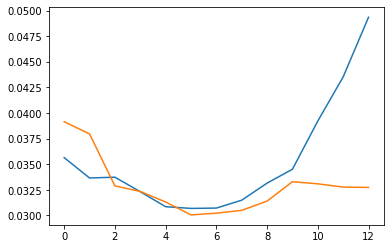

tensor([0.0356, 0.0360, 0.0335, 0.0311, 0.0296, 0.0301, 0.0306, 0.0315, 0.0333,
        0.0347, 0.0343, 0.0341, 0.0341])


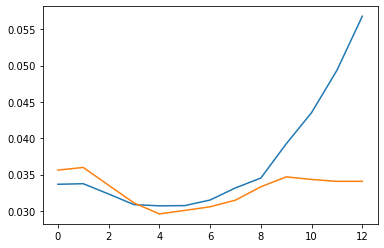

In [ ]:
def test_loop(model):
    numFeat = 10
    numOut = 4
    test_data = dataSetAll(2013,2100,numFeat,numOut)

    with torch.no_grad():
        for idx in range(len(test_data)):
            X = test_data[idx][0]
            Y = test_data[idx][1]
            feat = X[None,:]
            pred = model.predict(feat,numOut)[0]
            plt.plot(Y)
            print(pred)
            plt.plot(pred)
            
            plt.show()
            # break


def graph(model):
    numFeat = 10
    numOut = 4
    test_data = dataSetAll(2013,2100,numFeat,numOut)

    with torch.no_grad():
        predY = []
        actY = []
        for idx in range(len(test_data)):
            X = test_data[idx][0]
            y = test_data[idx][1]
            feat = X[None,:]

            pred = model.predict(feat,numOut)[0]
            future = 0

            predY.append(pred[numFeat-1::][future])
            actY.append(y[numFeat-1::][future])   
            
        plt.plot(actY) 
        plt.plot(predY)
        plt.show()

# graph(model)
test_loop(model)
